The spatial correction factor κ is derived from weekday averages; please comment on whether this remains valid for weekends/holidays. If possible, validate κ-corrected class shares at the 64 independent stations, not only total volumes.

In [119]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from sklearn.metrics import r2_score 

import seaborn as sns


# import custom modules
sys.path.append('../../utils')
import data_paths
import traffic_counts
import excel_calendar

## Import Data

In [120]:
# import visum traffic model and clip to ROI

visum = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')
roi_polygon = data_paths.MUNICH_BOARDERS_FILE # defines ROI for clipping
roi = gpd.read_file(roi_polygon).to_crs(visum.crs)
visum = gpd.clip(visum, roi)
visum = visum.explode(ignore_index=True)
visum['road_link_id'] = visum['road_link_id'].astype(int)

In [121]:
# import counting data and subselect valid counts in 2019
cnt_data_filename = data_paths.COMBINED_COUNTING_DATA
cnt_data = pd.read_parquet(cnt_data_filename)
cnt_data = cnt_data[cnt_data['date'].between('2019-01-01', '2019-12-31')]
cnt = cnt_data[cnt_data['valid']]

In [122]:
# subselect all road links where counting data is available
road_links_with_counter = cnt['road_link_id'].unique()
visum_cnt = visum[visum['road_link_id'].isin(road_links_with_counter)]

In [123]:
# initialize traffic counts class without timeprofile
cycles = traffic_counts.TrafficCounts(init_timeprofile=False)

## Processing

In [124]:
# get daily scaling factors and vehicle shares for 2019

dtv = pd.DataFrame()
shares = pd.DataFrame()

for idx in pd.date_range('2019-01-01', '2019-12-31', freq='D'):
    # scaling factors
    _df = pd.DataFrame(cycles.get_daily_scaling_factors(date=idx)).transpose()
    _df['date'] = idx
    dtv = pd.concat([dtv, _df], ignore_index=True)

    # vehicle shares
    _shares = cycles.get_vehicle_share(date = idx)
    _pc = pd.DataFrame(_shares).transpose()
    _pc['date'] = idx
    shares = pd.concat([shares, _pc])

dtv.set_index('date', inplace=True)
shares = shares.reset_index().set_index(['vehicle_class', 'date'])

In [125]:
# model traffic counts for all road links with counting data

modelled_count = pd.DataFrame()

for idx, row in visum_cnt.iterrows():
    
    rd_id = row['road_link_id']
    hgv_corr = row['hgv_corr']
    lcv_corr = row['lcv_corr']
    
    model_dtv = dtv[row['scaling_road_type']] * row['dtv_SUM'] 
    
    hgv = model_dtv * shares.loc['HGV'][row['scaling_road_type']] * row['hgv_corr']
    lcv = model_dtv * shares.loc['LCV'][row['scaling_road_type']] * row['lcv_corr']
    
    k = (1- (hgv_corr * shares.loc['HGV'][row['scaling_road_type']])-\
        (lcv_corr * shares.loc['LCV'][row['scaling_road_type']])) / \
        (1 - shares.loc['HGV'][row['scaling_road_type']] - shares.loc['LCV'][row['scaling_road_type']])
        
    #k = 1- (hgv_corr * shares.loc['HGV'][row['scaling_road_type']])/ \
    #    (1 - shares.loc['HGV'][row['scaling_road_type']])

    #lcv = model_dtv * shares.loc['LCV'][row['scaling_road_type']] * k
    pc = model_dtv * shares.loc['PC'][row['scaling_road_type']] * k
    mot = model_dtv * shares.loc['MOT'][row['scaling_road_type']] * k
    bus = model_dtv * shares.loc['BUS'][row['scaling_road_type']] * k
    
    df = pd.DataFrame({
        'SUM': model_dtv,
        'HGV': hgv,
        'LCV': lcv,
        'PC': pc,
        'MOT': mot,
        'BUS': bus
    })
    df.index.name = 'date'
    df['road_link_id'] = row['road_link_id']
    
    modelled_count = pd.concat([modelled_count, df.reset_index()], ignore_index=True)

# sum if multiple road links with same id exist (e.g. bidirectional counting station)
modelled_count = modelled_count.groupby(['road_link_id', 'date']).sum().reset_index()
modelled_count = modelled_count.set_index(['road_link_id', 'date'])
modelled_count

SUM          HGV          LCV            PC  \
road_link_id date                                                               
38           2019-01-01  55025.358786  2132.831352  5422.848626  47286.304756   
             2019-01-02  49740.291826  1249.268759  4468.191463  44015.559000   
             2019-01-03  59628.389601  2622.975291  5119.206809  51690.624419   
             2019-01-04  60001.083951  2488.050901  4457.459921  52897.943300   
             2019-01-05  46226.289040  1016.757898  3481.036279  41542.927049   
...                               ...          ...          ...           ...   
2147483452   2019-12-27  21994.689027   306.125240  1314.681463  20049.616717   
             2019-12-28  19626.211278   169.989578  1075.339690  18079.501179   
             2019-12-29  14785.608744    32.251174   587.163074  13933.800174   
             2019-12-30  23516.040555   321.417188  1345.659731  21481.243874   
             2019-12-31  16534.512621   111.413869  1126.742519  14996.192928   

                               MOT         BUS  
road_link_id date                               
38           2019-01-01  66.194953  117.179099  
             2019-01-02   1.818151    5.454452  
             2019-01-03  70.863436  124.719647  
             2019-01-04  63.802550   93.827279  
             2019-01-05  62.455027  123.112786  
...                            ...         ...  
2147483452   2019-12-27  53.237637  271.027970  
             2019-12-28  60.276166  241.104665  
             2019-12-29  36.619711  195.774611  
             2019-12-30  71.688486  296.031276  
             2019-12-31  79.530448  220.632857  

[27740 rows x 6 columns]

In [126]:
# prepare counted data
counted = cnt.pivot(index=['road_link_id', 'date'], columns='vehicle_class', values='daily_value')
counted

vehicle_class              BUS     HGV     LCV    MOT       PC      SUM
road_link_id date                                                      
3.800000e+01 2019-01-02    3.0     NaN     NaN    6.0      NaN      NaN
             2019-01-03  117.0  2235.0     NaN   50.0  54708.0  62116.0
             2019-01-04  100.0  2151.0     NaN   60.0  56378.0  63966.0
             2019-01-05  114.0   921.0     NaN   36.0  46229.0  51554.0
             2019-01-06   84.0   397.0     NaN   37.0  43520.0  47105.0
...                        ...     ...     ...    ...      ...      ...
2.147483e+09 2019-12-27  594.0   378.0  1262.0  163.0  18601.0  20998.0
             2019-12-28  540.0   253.0   937.0  123.0  16816.0  18669.0
             2019-12-29  434.0    54.0   753.0  113.0  14780.0  16134.0
             2019-12-30  607.0   380.0  1221.0  172.0  18624.0  21004.0
             2019-12-31  508.0     NaN     NaN  179.0  13764.0      NaN

[29785 rows x 6 columns]

In [127]:
# combine modelled and counted data
combined = modelled_count.merge(counted, left_index=True, right_index=True, suffixes=('_modelled', '_counted')).reset_index()
combined

,road_link_id,date,SUM_modelled,HGV_modelled,LCV_modelled,PC_modelled,MOT_modelled,BUS_modelled,BUS_counted,HGV_counted,LCV_counted,MOT_counted,PC_counted,SUM_counted
0,38,2019-01-02,49740.291826,1249.268759,4468.191463,44015.559000,1.818151,5.454452,3.0,NaN,NaN,6.0,NaN,NaN
1,38,2019-01-03,59628.389601,2622.975291,5119.206809,51690.624419,70.863436,124.719647,117.0,2235.0,NaN,50.0,54708.0,62116.0
2,38,2019-01-04,60001.083951,2488.050901,4457.459921,52897.943300,63.802550,93.827279,100.0,2151.0,NaN,60.0,56378.0,63966.0
3,38,2019-01-05,46226.289040,1016.757898,3481.036279,41542.927049,62.455027,123.112786,114.0,921.0,NaN,36.0,46229.0,51554.0
4,38,2019-01-06,44769.867087,445.305374,5339.910807,38806.313070,53.501351,124.836485,84.0,397.0,NaN,37.0,43520.0,47105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23588,2147483452,2019-12-27,21994.689027,306.125240,1314.681463,20049.616717,53.237637,271.027970,594.0,378.0,1262.0,163.0,18601.0,20998.0
23589,2147483452,2019-12-28,19626.211278,169.989578,1075.339690,18079.501179,60.276166,241.104665,540.0,253.0,937.0,123.0,16816.0,18669.0
23590,2147483452,2019-12-29,14785.608744,32.251174,587.163074,13933.800174,36.619711,195.774611,434.0,54.0,753.0,113.0,14780.0,16134.0
23591,2147483452,2019-12-30,23516.040555,321.417188,1345.659731,21481.243874,71.688486,296.031276,607.0,380.0,1221.0,172.0,18624.0,21004.0


In [ ]:
# add day-type and road type information to the dataframe
cal = excel_calendar.Calendar()

combined['day_type'] = combined['date'].apply(lambda x: cal.get_day_type(x))
combined['road_type'] = combined['road_link_id'].map(visum.groupby('road_link_id')['road_type'].first())



In [181]:
modelled_count.reset_index().nunique()

road_link_id       76
date              365
SUM             27729
HGV             27376
LCV             27740
PC              27740
MOT             27740
BUS             27740
dtype: int64

# Plotting

In [166]:
colors = dict(zip(combined['road_type'].unique(), sns.color_palette('colorblind')))

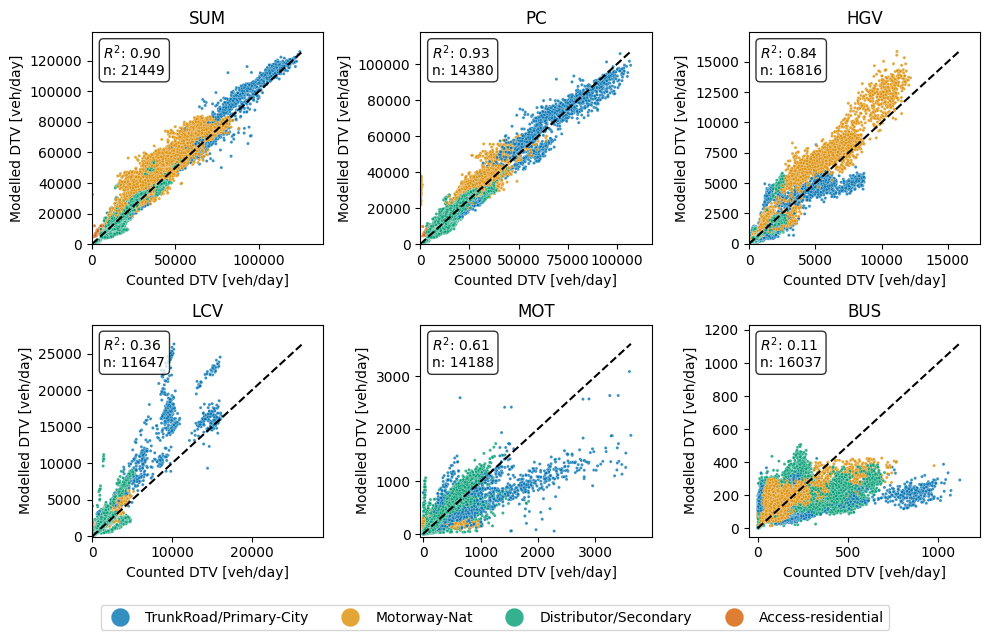

In [167]:
fig, ax = plt.subplots(2,3 ,figsize=(10,6), tight_layout=True)

i = 0
k = 0

for vc in ['SUM', 'PC', 'HGV', 'LCV', 'MOT', 'BUS']:
    
    df = combined.dropna(subset = [f'{vc}_modelled', f'{vc}_counted'])
    df = df[(df[vc+'_modelled'] > 0) & (df[vc+'_counted'] > 0)]
    
    sns.scatterplot(data= df,
                    y=f'{vc}_modelled', x=f'{vc}_counted', s=5, ax=ax[i,k],
                    palette= colors, hue = 'road_type', alpha = 0.8)
    
    ax[i,k].legend_.remove()
    
    ax[i,k].set_title(vc)
    ax[i,k].set_ylabel('Modelled DTV [veh/day]')
    ax[i,k].set_xlabel('Counted DTV [veh/day]')
    
    max_val = max(df[f'{vc}_modelled'].max(), df[f'{vc}_counted'].max())
    ax[i,k].plot([0, max_val], [0, max_val], color='black', linestyle='--')
    ax[i,k].set_xlim(-50, max_val*1.1)
    ax[i,k].set_ylim(-50, max_val*1.1)

    # add stats to plot
    r2 = r2_score(df[f'{vc}_counted'], df[f'{vc}_modelled'])
    n = len(df)
    
    
    ax[i,k].text(0.05, 0.95, f'$R^2$: {r2:.2f} \nn: {n}', transform=ax[i,k].transAxes,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # change to next subplot
    k += 1
    if k > 2:
        k = 0
        i += 1

# combined legend for all scatterplots
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), markerscale = 6, ncols = 4)

## same plot but only for weekend days

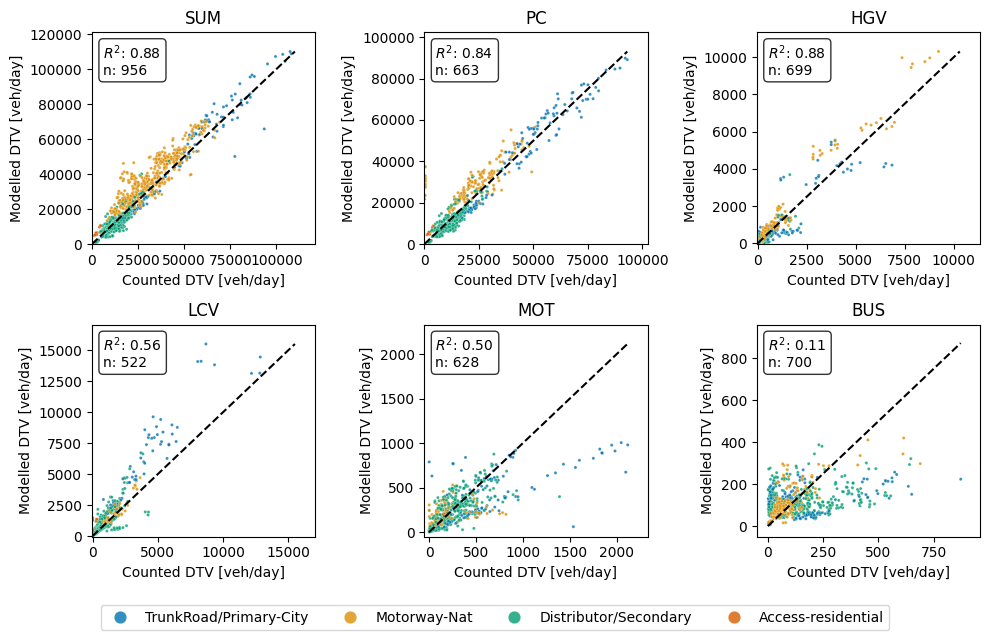

In [168]:
fig, ax = plt.subplots(2,3 ,figsize=(10,6), tight_layout=True)

i = 0
k = 0

for vc in ['SUM', 'PC', 'HGV', 'LCV', 'MOT', 'BUS']:
    
    df = combined.dropna(subset = [f'{vc}_modelled', f'{vc}_counted'])
    df = df[(df[vc+'_modelled'] > 0) & (df[vc+'_counted'] > 0) & (df['day_type'].isin([3,4]))]

    sns.scatterplot(data= df,
                    y=f'{vc}_modelled', x=f'{vc}_counted', s=5, ax=ax[i,k],
                    palette= colors, hue = 'road_type', alpha = 0.8)

    ax[i,k].legend_.remove()
    
    ax[i,k].set_title(vc)
    ax[i,k].set_ylabel('Modelled DTV [veh/day]')
    ax[i,k].set_xlabel('Counted DTV [veh/day]')
    
    max_val = max(df[f'{vc}_modelled'].max(), df[f'{vc}_counted'].max())
    ax[i,k].plot([0, max_val], [0, max_val], color='black', linestyle='--')
    ax[i,k].set_xlim(-50, max_val*1.1)
    ax[i,k].set_ylim(-50, max_val*1.1)
    
    # add stats to plot
    r2 = r2_score(df[f'{vc}_counted'], df[f'{vc}_modelled'])
    n = len(df)
    
    ax[i,k].text(0.05, 0.95, f'$R^2$: {r2:.2f} \nn: {n}', transform=ax[i,k].transAxes,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # change to next subplot
    k += 1
    if k > 2:
        k = 0
        i += 1

# combined legend for all scatterplots
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), markerscale = 4, ncols = 4)


# suptitle
#fig.suptitle('$\kappa$-corrected modelled vs. counted daily traffic volumes on Saturday and Sunday', fontsize=14)
plt.show()

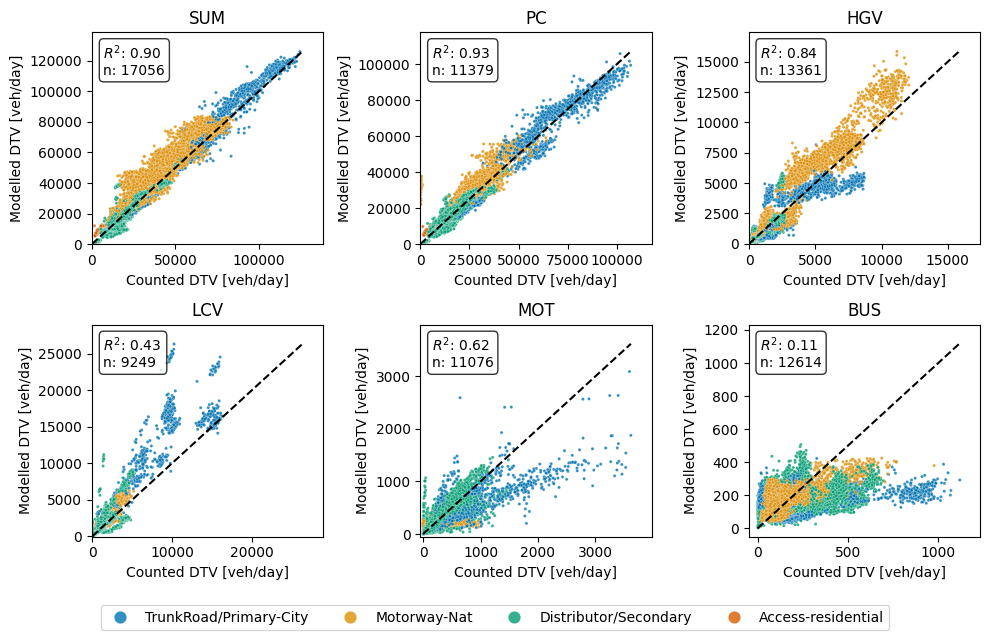

In [169]:
fig, ax = plt.subplots(2,3 ,figsize=(10,6), tight_layout=True)

i = 0
k = 0

for vc in ['SUM', 'PC', 'HGV', 'LCV', 'MOT', 'BUS']:
    
    df = combined.dropna(subset = [f'{vc}_modelled', f'{vc}_counted'])
    df = df[(df[vc+'_modelled'] > 0) & (df[vc+'_counted'] > 0) & (df['day_type'].isin([0,1,2]))]

    sns.scatterplot(data= df,
                    y=f'{vc}_modelled', x=f'{vc}_counted', s=5, ax=ax[i,k],
                    palette= colors, hue = 'road_type', alpha = 0.8)
    
    ax[i,k].legend_.remove()
    
    ax[i,k].set_title(vc)
    ax[i,k].set_ylabel('Modelled DTV [veh/day]')
    ax[i,k].set_xlabel('Counted DTV [veh/day]')

    max_val = max(df[f'{vc}_modelled'].max(), df[f'{vc}_counted'].max())
    ax[i,k].plot([0, max_val], [0, max_val], color='black', linestyle='--')
    ax[i,k].set_xlim(-50, max_val*1.1)
    ax[i,k].set_ylim(-50, max_val*1.1)
    
    # add stats to plot
    r2 = r2_score(df[f'{vc}_counted'], df[f'{vc}_modelled'])
    n = len(df)
    
    ax[i,k].text(0.05, 0.95, f'$R^2$: {r2:.2f} \nn: {n}', transform=ax[i,k].transAxes,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # change to next subplot
    k += 1
    if k > 2:
        k = 0
        i += 1

# combined legend for all scatterplots
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), markerscale = 4, ncols = 4)


# suptitle
#fig.suptitle('$\kappa$-corrected modelled vs. counted daily traffic volumes on Weekdays', fontsize=14)
plt.show()


In [175]:
cnt_data[cnt_data['valid']].nunique()

road_link_id            93
vehicle_class            6
date                   365
road_type                5
complete                 2
valid                    1
completness             87
scaling_road_type        3
sqv                    226
day_type                 5
daily_value          38493
0                     1932
1                     1355
2                     1042
3                      983
4                     1211
5                     3388
6                     5977
7                     6279
8                     6004
9                     5567
10                    5376
11                    5493
12                    5737
13                    5918
14                    6159
15                    6294
16                    6285
17                    6316
18                    6067
19                    5216
20                    4294
21                    3468
22                    2995
23                    2556
dtype: int64